# $\sigma^0$ from GEE + normalization

This code is a semi-automatic routine for the download of values of $\sigma^0$ from Sentinel-1 via the Google Earth Engine API. The downloaded data represent the mean value of $\sigma^0$ over the AoI, that must be provided manually into the code as a Java polygon or similar object; the variance of the data is provided as well.

---
**Dependencies** 

This code requires the installation of the Earth Engine API, `ee`. You can find more info on the installation procedure here: [Python installation of GEE](https://developers.google.com/earth-engine/guides/python_install). \
This code runs on browser-based notebooks only (Google Colaboratory, Jupyter Notebooks, etc...). \
Be aware that you won't need to install the Google Cloud APK to run the code. 

---
**Normalization**

After download, $\sigma^0$ values are normalized with respect to orbits. The chosen approach is based on the normalization of the values' distributions of different orbits on a reference distribution (Mladenova, 2013, DOI: 10.1109/TGRS.2012.2205264). The orbit that is chosen as reference by default is the one which average incidence angle is the closest to 40°.

---
**Output**

The output database has columns:
- Date: timestamp of date and time of passage rounded at hour
- Angle[°]: angle of incidence
- Geometry: name of AoI
- Orb: orbit relative number
- Pass: direction of passage, ascending or descending
- VV[dB], VH[dB]: mean values of $\sigma^0$, not normalized
- VV_var[dB], VH_var[dB]: variance of values of $\sigma^0$
- VV_norm[dB], VH_norm[dB]: mean values of $\sigma^0$, normalized

In [1]:
# Base
import os
import re
import ee
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.stats import norm, gamma, f, chi2
from scipy.signal import savgol_filter as sfilter

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import IPython.display as disp
%matplotlib inline

# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AWgavdeDwxIwmETekA81h6f84niUCba4J5sT7R9qnpnlGBC2MLh-Wk0WfRI



Successfully saved authorization token.


In [49]:
def skew_gauss(x, A, mean, dev, alpha,):
    """Skew, not-normalized and shifted gaussian distribution.

    References:
    - https://www.wolframalpha.com/input?i=skew+gaussian+distribution
    - https://stackoverflow.com/questions/15400850/scipy-optimize-curve-fit-unable-to-fit-shifted-skewed-gaussian-curve
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html

    """
    
    import math
    import scipy.special as sp
    
    pdf = (1/(dev*np.sqrt(2*np.pi)))*np.exp(-pow((x-mean),2)/(2*pow(dev,2)))
    cdf = sp.erfc((-alpha*(x-mean))/(dev*np.sqrt(2)))
    return A*pdf*cdf

#-----------------------------------------------------------------------------

def gauss(x, A, mean, dev):
    """Not-normalized, shifted gaussian distribution."""
    
    import math
    
    pdf = (1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))
    return A*pdf

#-----------------------------------------------------------------------------

def HIST_norm(ref_mean, ref_std, obs:list):
    """HIST normalization
    Ref. Mladenova, 2013, https://ieeexplore.ieee.org/document/6264094
    
    obs = [value, mean, std]
    """
    value, mean, std = obs
    return ref_mean+ref_std/std*(value-mean)

#-----------------------------------------------------------------------------

In [47]:
# Extract data
print('Mean is computed by spatial average in linear scale.\n'+
      'Std is the square root of variance in linear scale, '+
      'transformed in dB by mantaining constant relative error.')

#-----------------------------------------------------------------------------

def lin_db(x):
    return 10*np.log10(x)

def db_lin(x):
    return 10**(x/10)

#-----------------------------------------------------------------------------

def extract_data(image:ee.Image):
    """Ausiliary function to extract data from an Image
    
    This function extracts spatial means and std.dev
    via spatial reducers (reduceRegion).
    Optimal implementation is to map this function
    on a whole ImageCollection via .map() and insert the
    return into a ee.FeatureCollection.
    
    Return
    ------
    ee.Feature
    
    """
    try: # be aware that this try doesn't do anything
        mean = image.reduceRegion(**{ 
            'reducer': ee.Reducer.mean(),
            'geometry': aoi,
        })
        
        dev = image.reduceRegion(**{ 
            'reducer': ee.Reducer.stdDev(),
            'geometry': aoi,
        })
        
        var = image.reduceRegion(**{
            'reducer':ee.Reducer.variance(),
            'geometry': aoi,
        })
    
        properties = {
            'Date': image.get('system:time_start'), # only way to get a timestr is an external operation
            'Geometry': geometry_title,
            'VV[lin]': mean.get('VV'),
            'VH[lin]': mean.get('VH'),
            'Angle[°]': mean.get('angle'),
            'VV_var[lin]': var.get('VV'),
            'VH_var[lin]': var.get('VH'),
            'Orb': image.get('relativeOrbitNumber_start'),
            'Pass': image.get('orbitProperties_pass'),
        }
    except (HttpError, EEException):
        print(f'This image ({image.get("ID")}) had missing data. Skip...\n')
            
            
    return ee.Feature(None, properties)

#-----------------------------------------------------------------------------

Mean is computed by spatial average in linear scale.
Std is the square root of variance in linear scale, transformed in dB by mantaining constant relative error.


In [80]:
# Filters definition
# fil_orb95   = ee.Filter.eq('relativeOrbitNumber_start', 95)
# fil_orb168  = ee.Filter.eq('relativeOrbitNumber_start', 168)
# fil_orb117 = ee.Filter.eq('relativeOrbitNumber_start', 117)

sp17 = ee.Filter.date('2017-04-04', '2017-05-22') # related to Budrio field
su17 = ee.Filter.date('2017-05-22', '2017-09-15') # related to Budrio field
au17 = ee.Filter.date('2017-09-15', '2017-11-02') # related to Budrio field

# missing data on 2016-10-01 raises not-exceptable exception
# tot = ee.Filter.date('2014-10-03', '2022-12-01')

tot1 = ee.Filter.date('2014-10-03', '2016-09-30')
tot2 = ee.Filter.date('2016-10-02', '2022-12-01')

In [111]:
# Define area of interest
# If you have a GeoJSON file, copy paste.
# If you have a KML, export to GeoJSON (plenty of free tools online)
# or retrieve P

geoJSON = {"type":"FeatureCollection", "features": [
{"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[11.347035987013012,43.951592805194856],[11.347393649350675,43.95121129870136],[11.346869077922104,43.95095696103902],[11.346718064935093,43.950774155844215],[11.34676575324678,43.95059929870136],[11.347163155844182,43.95046418181824],[11.347282376623403,43.95048007792214],[11.347139311688338,43.95064698701305],[11.347123415584441,43.95076620779227],[11.347401597402623,43.95084568831175],[11.34753671428574,43.951020545454604],[11.347647987013012,43.95101259740266],[11.347870532467557,43.9508377402598],[11.353148038961045,43.954644857142895],[11.352846012987019,43.95487535064939],[11.352607571428578,43.954692545454584],[11.352416818181826,43.95466075324679],[11.352337337662346,43.954764077922114],[11.352472454545463,43.95495483116887],[11.35244066233767,43.9550263636364],[11.352138636363645,43.95519327272731],[11.351741233766244,43.955368129870166],[11.351502792207803,43.95527275324679],[11.351224610389623,43.955439662337696],[11.35095437662339,43.955415818181855],[11.34934092207794,43.95366724675329],[11.34804538961041,43.952236597402646],[11.347035987013012,43.951592805194856]]]},"properties":{"id":1}}
]}
nfeatures = 1
coords = [geoJSON['features'][i]['geometry']['coordinates'] for i in range(nfeatures)]
aoi = ee.Geometry.MultiPolygon(coords)

geometry_title = input('Please provide a title for AoI geometry. (Default: Budrio_half-right)')
if not geometry_title: geometry_title='Budrio_half-right'

Please provide a title for AoI geometry. (Default: Budrio_half-right) sanlorenzo2


In [112]:
# Get collection of images and filter
img1 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # linear scale for mean, var computation
        .filterBounds(aoi)
        .filter(tot1)
        .sort('system:time_start'))
img2 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') # linear scale for mean, var computation
        .filterBounds(aoi)
        .filter(tot2)
        .sort('system:time_start'))

# acq_times = img.aggregate_array('system:time_start').getInfo()
# len([time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times])

In [113]:
def clean_date(date:int):
    return time.strftime('%x %H', time.localtime((date)/1000))

dflist = []
for img in [img1, img2]:
    data = ee.FeatureCollection(img.map(extract_data))
    data_out = data.getInfo()
    data_out_to_df = [e.get('properties') for e in data_out.get('features')]; data_out_to_df[0]
    df = pd.DataFrame.from_dict(data_out_to_df)
    df.Date = df.Date.apply(lambda x : pd.to_datetime(clean_date(x)))
    df['VV[dB]'] = df['VV[lin]'].apply(lambda x : lin_db(x))
    df['VH[dB]'] = df['VH[lin]'].apply(lambda x : lin_db(x))
    df['VV_var[dB]'] = df['VV_var[lin]']/df['VV[lin]']*(10/np.log(10))
    df['VH_var[dB]'] = df['VH_var[lin]']/df['VH[lin]']*(10/np.log(10))
    dflist.append(df)

dftot = pd.concat([dflist[0],dflist[1]]).set_index('Date'); dftot

,Angle[°],Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB]
Date,,,,,,,,,,,,
2014-10-06 19:00:00,45.176144,sanlorenzo2,17,ASCENDING,0.019004,0.000053,0.082849,0.001751,-10.817146,-17.211607,0.091792,0.012072
2014-10-12 07:00:00,41.305447,sanlorenzo2,95,DESCENDING,0.028798,0.000144,0.117001,0.002267,-9.318103,-15.406314,0.084161,0.021738
2014-10-13 19:00:00,35.611549,sanlorenzo2,117,ASCENDING,0.039756,0.000248,0.154436,0.003612,-8.112510,-14.005922,0.101567,0.027105
2014-10-18 19:00:00,45.174881,sanlorenzo2,15,ASCENDING,0.022106,0.000101,0.091743,0.001750,-10.374291,-16.554832,0.082821,0.019858
2014-10-24 07:00:00,41.307316,sanlorenzo2,95,DESCENDING,0.018979,0.000081,0.079413,0.001485,-11.001062,-17.217329,0.081194,0.018641
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17 18:00:00,44.931568,sanlorenzo2,15,ASCENDING,0.011013,0.000041,0.043601,0.000412,-13.605052,-19.580827,0.041064,0.016059
2022-11-23 06:00:00,41.404713,sanlorenzo2,95,DESCENDING,0.013868,0.000045,0.059168,0.000842,-12.279155,-18.579794,0.061802,0.014218
2022-11-24 18:00:00,35.768028,sanlorenzo2,117,ASCENDING,0.011862,0.000056,0.055065,0.000781,-12.591264,-19.258401,0.061628,0.020546


# Backscattering normalization

Ref: DOI: 10.1109/tgrs.2012.2205264, https://ieeexplore.ieee.org/document/6264094 (Mladenova (2013))

In [114]:
import warnings

# need orbits in databaes: exploit sets' uniquity
orb_list = [*set(dftot.Orb.values)]

n=0
leng_list=[]
for orb in orb_list:
    leng = len(dftot[dftot.Orb==orb]) 
    print(f'orbit {orb} has {leng} data')
    if leng==1:
        warnings.warn(f'\nOrbit {orb} has only 1 datum. '+
                      'This orbit will be ignored.')
    leng_list.append(leng)
    n+=leng
print(f'total number of data is {n}')

bad_orb_list=[orb_list[i] for i in range(len(orb_list)) if leng_list[i]==1]
orb_list=[orb_list[i] for i in range(len(orb_list)) if leng_list[i]>1]; orb_list

for bad in bad_orb_list:
    dftot=dftot.drop(dftot[dftot.Orb==bad].index)

orbit 168 has 385 data
orbit 14 has 1 data
orbit 15 has 387 data
orbit 17 has 1 data
orbit 117 has 394 data
orbit 95 has 386 data
total number of data is 1554


C:\Users\MARTINA\AppData\Local\Temp/ipykernel_14532/2177166141.py:12: UserWarning: 
Orbit 14 has only 1 datum. This orbit will be ignored.
  warnings.warn(f'\nOrbit {orb} has only 1 datum. '+
C:\Users\MARTINA\AppData\Local\Temp/ipykernel_14532/2177166141.py:12: UserWarning: 
Orbit 17 has only 1 datum. This orbit will be ignored.
  warnings.warn(f'\nOrbit {orb} has only 1 datum. '+


In [115]:
normdict = dict()
nnormdict = dict()

for orb in orb_list:
    d = dict()
    for pol in ['VV','VH']:
        d[f'{pol}']      = dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values
        d[f'{pol}_mean'] = np.mean(dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values)
        d[f'{pol}_std']  = np.std(dftot.loc[dftot.Orb==orb][f'{pol}[dB]'].values)
        if d[f'{pol}_std']==0: d[f'{pol}_std']=np.sqrt(abs(d[f'{pol}_mean']))
        d[f'angle_mean'] = np.mean(dftot.loc[dftot.Orb==orb][f'Angle[°]'].values)
    d['angle'] = dftot.loc[dftot.Orb==orb][f'Angle[°]'].values
    normdict[orb] = d
    
normdf = pd.DataFrame.from_dict(normdict, orient='index'); normdf
statsnorm = normdf.drop(columns=['VV','VH','angle']); statsnorm

,VV_mean,VV_std,angle_mean,VH_mean,VH_std
168,-10.993136,1.485946,31.455255,-18.198809,1.857952
15,-13.025739,1.404767,44.740118,-19.254469,1.463194
117,-11.814813,1.392238,35.729835,-18.367437,1.507186
95,-12.219192,1.380478,41.501752,-18.987825,1.772151


In [116]:
# Find orbit that has mean angle nearest to 40°
# and choose it as reference statistics
orb_ref = normdf.angle_mean.apply(lambda x : abs(x-40)).sort_values().head(1).index.values[0]
if not input(f'The orbit with mean incidence angle nearest to 40° is orbit {orb_ref}. '+
             'This orbit will be taken as reference orbit for normalization. Proceed? [[]/any]')=='':
    raise NameError('Manually set orb_ref variable with chosen reference orbit (type:int).')
else: print(f'\nOrbit {orb_ref} has been set as reference orbit.')

The orbit with mean incidence angle nearest to 40° is orbit 95. This orbit will be taken as reference orbit for normalization. Proceed? [[]/any] 



Orbit 95 has been set as reference orbit.


In [117]:
for orb in orb_list:
    d = dict()
    for pol in ['VV', 'VH']:
        d[f'{pol}']      = HIST_norm(
            normdf.loc[orb_ref][f'{pol}_mean'],
            normdf.loc[orb_ref][f'{pol}_std'],
            [
                normdf.loc[orb][pol],
                normdf.loc[orb][f'{pol}_mean'],
                normdf.loc[orb][f'{pol}_std'],
            ]
                 )
        d[f'{pol}_mean'] = np.mean(d[f'{pol}'])
        d[f'{pol}_std']  = np.std(d[f'{pol}'])
    nnormdict[orb] = d
    
nnormdf = pd.DataFrame.from_dict(nnormdict, orient='index'); nnormdf

,VV,VV_mean,VV_std,VH,VH_mean,VH_std
168,"[-10.585982394169966, -11.310283156280914, -11...",-12.219192,1.380478,"[-17.43427188532769, -17.409011982853116, -17....",-18.987825,1.772151
15,"[-9.613588597493669, -11.127224982084066, -9.1...",-12.219192,1.380478,"[-15.718152652533359, -16.97204078070087, -15....",-18.987825,1.772151
117,"[-8.548162243250527, -11.031107252616666, -8.8...",-12.219192,1.380478,"[-13.859550844269137, -16.367598345800914, -13...",-18.987825,1.772151
95,"[-9.318103198940541, -11.001062353677536, -9.7...",-12.219192,1.380478,"[-15.406313503466265, -17.217328820144907, -15...",-18.987825,1.772151


In [118]:
dftot['VV_norm[dB]']= dftot.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VV_mean'][orb_ref],
        statsnorm['VV_std'][orb_ref],
        [   
            x['VV[dB]'],    
            statsnorm['VV_mean'][x.Orb],    
            statsnorm['VV_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

dftot['VH_norm[dB]']= dftot.apply( 
    lambda x :
    HIST_norm(
        statsnorm['VH_mean'][orb_ref],
        statsnorm['VH_std'][orb_ref],
        [   
            x['VH[dB]'],    
            statsnorm['VH_mean'][x.Orb],    
            statsnorm['VH_std'][x.Orb]
        ],   
    ),
    axis='columns',
)

In [119]:
dftot=dftot.drop(['VH[lin]','VH_var[lin]','VV[lin]','VV_var[lin]'], axis=1)
dftot.drop_duplicates(inplace=True)
dftot.dropna(inplace=True)
dftot

,Angle[°],Geometry,Orb,Pass,VV[dB],VH[dB],VV_var[dB],VH_var[dB],VV_norm[dB],VH_norm[dB]
Date,,,,,,,,,,
2014-10-12 07:00:00,41.305447,sanlorenzo2,95,DESCENDING,-9.318103,-15.406314,0.084161,0.021738,-9.318103,-15.406314
2014-10-13 19:00:00,35.611549,sanlorenzo2,117,ASCENDING,-8.112510,-14.005922,0.101567,0.027105,-8.548162,-13.859551
2014-10-18 19:00:00,45.174881,sanlorenzo2,15,ASCENDING,-10.374291,-16.554832,0.082821,0.019858,-9.613589,-15.718153
2014-10-24 07:00:00,41.307316,sanlorenzo2,95,DESCENDING,-11.001062,-17.217329,0.081194,0.018641,-11.001062,-17.217329
2014-10-25 19:00:00,35.614376,sanlorenzo2,117,ASCENDING,-10.616607,-16.138976,0.068478,0.018456,-11.031107,-16.367598
...,...,...,...,...,...,...,...,...,...,...
2022-11-17 18:00:00,44.931568,sanlorenzo2,15,ASCENDING,-13.605052,-19.580827,0.041064,0.016059,-12.788489,-19.383094
2022-11-23 06:00:00,41.404713,sanlorenzo2,95,DESCENDING,-12.279155,-18.579794,0.061802,0.014218,-12.279155,-18.579794
2022-11-24 18:00:00,35.768028,sanlorenzo2,117,ASCENDING,-12.591264,-19.258401,0.061628,0.020546,-12.989084,-20.035421


In [120]:
opt_save_df = input('Save df? [y/n]')
if opt_save_df=='y':
    filename = input('Provide filename without extension (def. .csv): [default:geometry name] ')
    if filename=='': filename = geometry_title 
    dftot.to_csv(f'..\Data\{filename}.csv', sep = '\t')

Save df? [y/n] y
Provide filename without extension (def. .csv): [default:geometry name]  


# Snippets

## Plots

In [147]:
def hist_gauss_fit(data, nbins, hist_kwargs, fitline_kwargs,
                   title, density=True, opt_save=False, opt_name='hist_fit',
                  ):
    
    def gauss(x, A, mean, dev):
        """Not-normalized, shifted gaussian distribution."""
        import math
        return A*(1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))

    counts, bins, pads = plt.hist(data, bins=nbins, density=True, **hist_kwargs)
    fit_bounds = [ [0,min(bins),0], [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))] ]
    popt, pcov = curve_fit(gauss, bins[:-1], counts, method='trf',bounds=fit_bounds, maxfev=1000)
    A, mean, dev = popt[0], popt[1], popt[2]
    x = np.linspace(min(data), max(data), 50)
    fit = gauss(x, A, mean, dev)
    plt.plot(x, fit, **fitline_kwargs)
    ylabel = 'Density' if density else 'Counts';    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    if opt_save: plt.savefig(opt_name+'.png', dpi=300)
    return counts, bins, pads

Save plots? [y/n] n


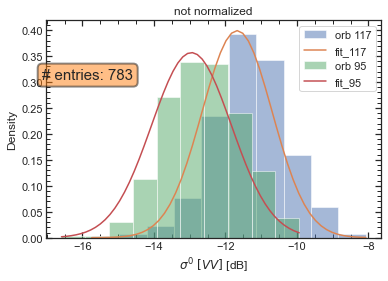

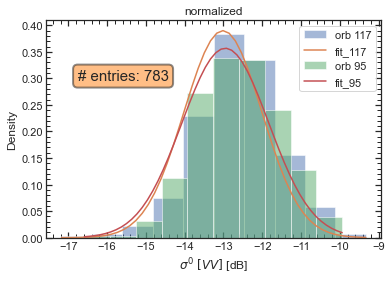

In [191]:
# Histograms plots

opt_save=True if input('Save plots? [y/n]')=='y' else False

normdf.dropna(inplace=True)
nnormdf.dropna(inplace=True)

# Not normalized
plt.figure()
for orb in orb_list:
    hist_kwargs={'alpha':.5, 'label':f'orb {orb}'}
    fitline_kwargs={'linestyle':'-', 'label':f'fit_{orb}'}
    data = normdf['VV'][orb]
    hist_gauss_fit(data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                   title='not normalized', density=True, opt_save=opt_save, opt_name='hist_2014-22_fit_not-norm',)
    plt.xlabel(r'$\sigma^0\ [VV]$ [dB]')
t = plt.text(np.min(bins)+1, 0.9*np.max(counts),
             f'# entries: {len(dftot.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

# Normalized
plt.figure()
for orb in orb_list:
    hist_kwargs={'alpha':.5, 'label':f'orb {orb}'}
    fitline_kwargs={'linestyle':'-', 'label':f'fit_{orb}'}
    data = nnormdf['VV'][orb]
    counts, bins, pads = hist_gauss_fit(data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                   title='normalized', density=True, opt_save=opt_save, opt_name='hist_2014-22_fit_norm',)
    plt.xlabel(r'$\sigma^0\ [VV]$ [dB]')
t = plt.text(np.min(bins)+1, 0.9*np.max(counts),
             f'# entries: {len(dftot.index)}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

Save plot? [y/n] n


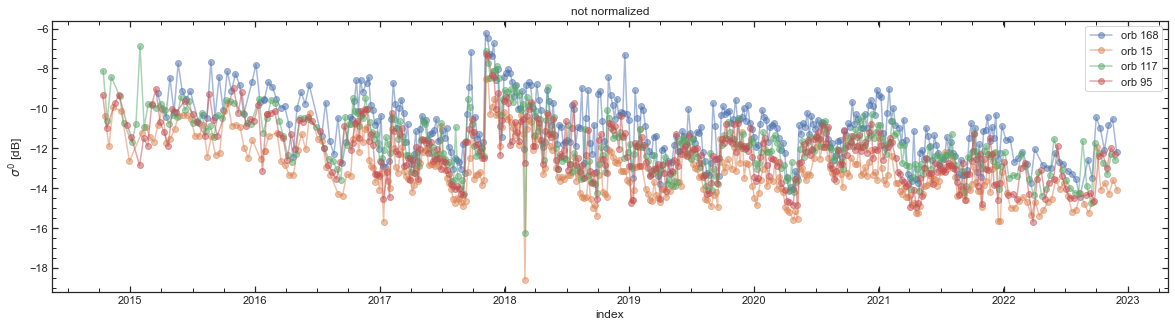

In [114]:
# Timeseries, before normalization

plot_name = 'sigma_norm_2014-22_'
opt_save = True if input('Save plot? [y/n]')=='y' else False
plt.figure(figsize=(20,5))

for orb in orb_list:
    plt.plot(dftot[dftot.Orb==orb]['VV[dB]'], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('not normalized')
if opt_save: plt.savefig(plot_name+'plot_not-norm.png', dpi=300)
plt.show()

Save plot? [y/n] n


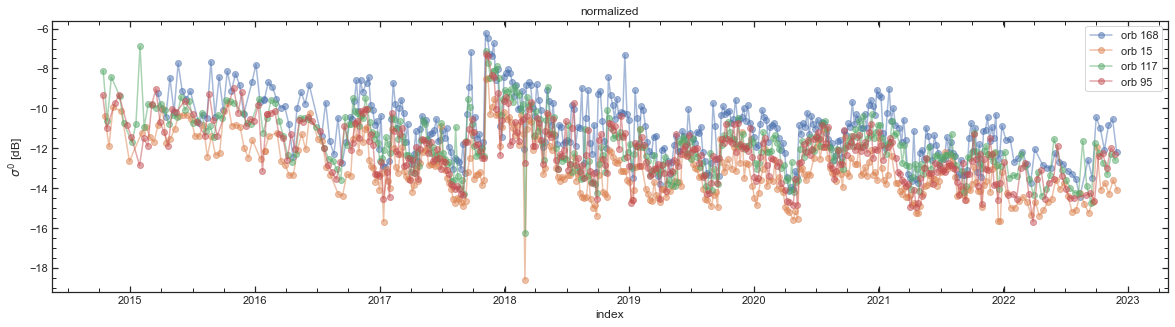

In [115]:
# Timeseries, after normalization

plot_name = 'sigma_norm_2014-22_'
opt_save = True if input('Save plot? [y/n]')=='y' else False

plt.figure(figsize=(20,5))
for orb in orb_list:
    plt.plot(dftot[dftot.Orb==orb].index, dftot[dftot.Orb==orb]['VV[dB]'], alpha=.5, marker='o', linestyle='-', label=f'orb {orb}')
plt.ylabel(r'$\sigma^0$ [dB]')
plt.xlabel('index')
plt.legend(loc='best')
plt.title('normalized')
if opt_save: plt.savefig(plot_name+'plot_norm.png', dpi=300)
plt.show()

In [56]:
raise Exception('Surprise! Stop right here! :) \nBelow there is code with other purposes...')

Exception: Surprise! Stop right here! :) 
Below there is code with other purposes...

# Merging with in-situ data

Ref: Building_Golden.ipynb

In [31]:
# Platinum_Budrio has 2 sheets, one for 2017, one for 2020

import datetime as dtt

database = pd.ExcelFile('..\\Data\\Platinum_Budrio.xlsx', engine='openpyxl')

data_1h_2017 = database.parse('2017_1h')
data_1h_2017['Ora'] = pd.to_datetime(data_1h_2017['Ora'].astype('str')).apply(lambda x: x.time())
data_1h_2017['BiOra'] = data_1h_2017['Ora'].apply(lambda x: 2*np.around(x.hour/2))
data_1h_2017['Data'] = pd.to_datetime(data_1h_2017['Data'].astype('str')).apply(lambda x: x.date())
data_1h_2017['Mese'] = data_1h_2017['Data'].apply(lambda x: x.month)
data_1h_2017['Date'] = data_1h_2017.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
data_1h_2017 = data_1h_2017.drop(['ID', 'Data', 'Ora', '214Pb[cps]', 'BiOra', 'Mese'],axis=1)
data_1h_2017

,SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],Date
0,0.173254,0.0,0.0,17.4097,2017-04-03 11:00:00
1,0.174514,0.0,0.0,19.1982,2017-04-03 12:00:00
2,0.178998,0.0,0.0,20.9032,2017-04-03 13:00:00
3,0.206764,0.0,0.0,21.8341,2017-04-03 14:00:00
4,0.169945,0.0,0.0,22.3737,2017-04-03 15:00:00
...,...,...,...,...,...
5120,0.139442,0.0,0.0,11.3791,2017-11-02 19:00:00
5121,0.135318,0.0,0.0,10.9391,2017-11-02 20:00:00
5122,0.149532,0.0,0.0,10.7549,2017-11-02 21:00:00
5123,0.130251,0.0,0.0,11.1445,2017-11-02 22:00:00


In [32]:
golden = pd.merge(left=df, right=data_1h_2017, how='left', on='Date').iloc[:-3]; golden

,Angle[°],Date,Geometry,Orb,Pass,VH[lin],VH_var[lin],VV[lin],VV_var[lin],VV[dB],VH[dB],VV_var[dB],VH_var[dB],SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C]
0,31.282551,2017-04-04 07:00:00,Budrio_half-right,168,DESCENDING,0.009136,0.000018,0.070329,0.000630,-11.528672,-20.392462,0.038881,0.008441,0.170173,0.0,0.0,8.7339
1,41.103306,2017-04-05 07:00:00,Budrio_half-right,95,DESCENDING,0.006342,0.000010,0.090708,0.001534,-10.423533,-21.977589,0.073466,0.006573,0.147105,0.0,0.0,11.8548
2,37.537476,2017-04-06 19:00:00,Budrio_half-right,117,ASCENDING,0.005942,0.000007,0.062548,0.000390,-12.037891,-22.260785,0.027052,0.004964,0.150527,0.0,0.0,15.6591
3,31.368000,2017-04-10 07:00:00,Budrio_half-right,168,DESCENDING,0.006690,0.000009,0.066282,0.000831,-11.786029,-21.745415,0.054418,0.005718,0.159550,0.0,0.0,8.5507
4,41.305325,2017-04-11 07:00:00,Budrio_half-right,95,DESCENDING,0.005057,0.000007,0.056139,0.000400,-12.507326,-22.961495,0.030916,0.005962,0.160673,0.0,0.0,10.5575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,41.293633,2017-10-26 07:00:00,Budrio_half-right,95,DESCENDING,0.011202,0.000027,0.093611,0.000985,-10.286710,-19.507143,0.045695,0.010312,0.155637,0.0,0.0,5.1388
103,37.531326,2017-10-27 19:00:00,Budrio_half-right,117,ASCENDING,0.012791,0.000031,0.069743,0.000667,-11.565022,-18.931034,0.041511,0.010434,0.155525,0.0,0.0,14.4822
104,31.386597,2017-10-31 06:00:00,Budrio_half-right,168,DESCENDING,0.010243,0.000017,0.159341,0.004745,-7.976737,-19.895653,0.129336,0.007121,0.167105,0.0,0.0,4.9978
105,41.307350,2017-11-01 06:00:00,Budrio_half-right,95,DESCENDING,0.011606,0.000018,0.090067,0.000921,-10.454340,-19.353215,0.044419,0.006885,0.124052,NaN,0.0,NaN


In [33]:
save = input("Wanna save in Data directory? [y/n] ")
if save=='y': golden.to_csv(f'..\Data\Golden_GEE.csv', sep = '\t')

Wanna save in root directory? [y/n]  y
